## Demonstrating Model Variance Reduction through Bootstrap Resampling and Ridge Regularization

#### Abdulaziz Aldossary, aa98769
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Elnara Rustamzade, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/elnara-rustamzade/)

### Executive Summary
This notebook demonstrates how model variance changes under bootstrap resampling and how ridge regularization reduces that variance relative to ordinary least squares. Using a synthetic dataset (`unconv_MV_v5.csv`), we downsample to a sparse regime (n=20) to stress variance, train/test split at 80/20, and evaluate linear regression (α=0) and ridge models (α ∈ {0.1, 1, 10, 100}). We perform 200 bootstrap resamples of the training set, fit each model to each resample, and analyze the variability of predictions and coefficients on a fixed test set. Results support the hypothesis: increasing ridge regularization systematically decreases both coefficient and prediction variance, improving stability and mitigating sensitivity to sampling noise.


### Project Goals 
1. Quantify prediction and coefficient variance under bootstrap resampling for linear models.
2. Demonstrate how ridge regularization reduces variance compared to ordinary least squares.


### Load the Required Libraries & Packages

We begin by importing the essential Python libraries used throughout this workflow.  These packages provide the core functionality needed for data handling, preprocessing, regression modeling, bootstrap resampling, and visualization.  Only the tools directly required for demonstrating model variance and the effect of ridge regularization are included to keep the workflow clean and focused.

In [2]:
import numpy as np                         # numerical computations
import pandas as pd                        # data loading and tables
import matplotlib.pyplot as plt            # plotting
from matplotlib.lines import Line2D        # custom legend elements

from sklearn.model_selection import train_test_split        # train/test split
from sklearn.preprocessing import StandardScaler            # feature scaling
from sklearn.pipeline import Pipeline                       # combine steps cleanly
from sklearn.linear_model import LinearRegression, Ridge    # OLS and Ridge models
from sklearn.utils import resample                          # bootstrap resampling
from sklearn.metrics import mean_squared_error              # model performance metric

### Functions

This section defines the core utility functions used throughout the workflow. Each function encapsulates a repeated operation so the notebook remains compact, readable, and easy for another student to follow. These functions directly support the main objectives of the analysis—constructing standardized models, performing bootstrap resampling, and evaluating prediction stability.

In [4]:
def make_model_pipeline(model):
    """
    Wrap a regression model with standardization in a Pipeline.
    Used to ensure fair comparison between OLS and Ridge.
    """
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", model)
    ])
    return pipe


def bootstrap_model(pipe, X_train, y_train, X_test, n_boot=200, random_state=42):
    """
    Run bootstrap resampling with a given pipeline.
    For each bootstrap sample: fit the model and store predictions and coefficients.
    Used to estimate prediction and coefficient variance.
    """
    rng = np.random.RandomState(random_state)
    n_features = X_train.shape[1]
    
    all_preds = np.zeros((n_boot, X_test.shape[0]))
    all_coefs = np.zeros((n_boot, n_features))
    
    for i in range(n_boot):
        X_res, y_res = resample(X_train, y_train, random_state=rng.randint(0, 1_000_000))
        pipe.fit(X_res, y_res)
        
        all_preds[i, :] = pipe.predict(X_test)
        
        # Access underlying regression coefficients after scaling
        reg = pipe.named_steps["regressor"]
        scaler = pipe.named_steps["scaler"]
        coefs = reg.coef_ / scaler.scale_    # convert back to original feature scale
        all_coefs[i, :] = coefs
    
    return all_preds, all_coefs


def compute_bootstrap_mse(pred_matrix, y_test):
    """
    Compute MSE for each bootstrap prediction matrix.
    Used to summarize how model error varies across resamples.
    """
    n_boot = pred_matrix.shape[0]
    mse_values = np.zeros(n_boot)
    
    for i in range(n_boot):
        mse_values[i] = mean_squared_error(y_test, pred_matrix[i, :])
    
    return mse_values

### Load Dataset

We use the synthetic unconventional reservoir dataset **`unconv_MV_v5.csv`** created and published by  
Professor Michael Pyrcz through his open **GeoDataSets** GitHub repository.  
The dataset is fully public and reproducible, making it ideal for educational machine learning workflows.

In this project, we focus on the following features:

- **Por** – Reservoir porosity (%), representing the fraction of pore space in the rock.  
- **Brittle** – Brittleness index (%), indicating how easily the rock fractures under stress.  
- **Perm** – Permeability (mD), describing the ability of fluids to flow through the rock.  
- **TOC** – Total Organic Carbon (%), an indicator of source rock richness.  
- **AI** – Acoustic Impedance, measured in ($\frac{kg}{m^3} \cdot \frac{m}{s} \cdot 10^3$). 
  commonly used in seismic and petrophysical analysis.  
- **Prod** – Gas production (MCFD), which is the target variable in this workflow.

We load the dataset directly from the cloud to ensure full reproducibility.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV_v5.csv')

# Feature set: core predictors for production forecasting
feature_cols = ["Por", "Brittle", "Perm", "TOC", "AI"]   # candidate predictors
target_col = "Prod"                                        # response variable

df = df[feature_cols + [target_col]]

df.head()

,Por,Brittle,Perm,TOC,AI,Prod
0,12.08,81.40,2.92,1.16,2.80,4165.196191
1,12.38,46.17,3.53,0.89,3.22,3561.146205
2,14.02,72.80,2.59,0.89,4.01,4284.348574
3,17.67,39.81,6.75,1.08,2.63,5098.680869
4,17.52,10.94,4.57,1.51,3.18,3406.132832


### Summary Statistics

Before proceeding with bootstrap resampling or model comparison, we first examine the descriptive statistics of the dataset.  
This provides a quick understanding of the central tendency, spread, and range of each predictor and the target variable.

In this step, we compute key summary statistics (mean, standard deviation, min/max, and percentiles) for all features used in the workflow.  
This helps verify that:

- the uploaded dataset loaded correctly,  
- the variables fall within physically reasonable reservoir ranges,  
- no unexpected truncation or missing values are present, and  
- the sampling space is sufficiently broad to support variance analysis.

This check ensures that the downsampling step performed later in the workflow represents meaningful variability across the dataset.

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Por,200.0,14.991150,2.971176,6.550000,12.912500,15.070000,17.402500,23.550000
Brittle,200.0,48.161950,14.129455,10.940000,37.755000,49.510000,58.262500,84.330000
Perm,200.0,4.330750,1.731014,1.130000,3.122500,4.035000,5.287500,9.870000
TOC,200.0,0.990450,0.481588,-0.190000,0.617500,1.030000,1.350000,2.180000
AI,200.0,2.968850,0.566885,1.280000,2.547500,2.955000,3.345000,4.630000
Prod,200.0,4311.219852,992.038414,2107.139414,3618.064513,4284.687348,5086.089761,6662.622385


### Summary Statistics Interpretation

The summary table shows that all selected predictor variables contain the same number of observations as the target variable **`Prod`**, which confirms complete coverage with no missing values. The feature ranges appear reasonable for this synthetic dataset, and no variables show extreme or unexpected values that would require immediate truncation or correction.

Overall, the dataset is clean and consistent, providing a reliable foundation for the next steps of the workflow. We can now proceed to constructing the variance-sensitive subsample and begin exploring how model variability behaves under bootstrap resampling and ridge regularization.

### Project Approach

The goal of this workflow is to build an **educational demonstration** of how model variance behaves under bootstrap resampling and how **ridge regularization** can reduce that variance compared to ordinary least squares (OLS). To keep the story clear and easy to follow, the workflow is organized into four main steps:

#### 1- Construct a Variance-Sensitive Regression Setup  
With the dataset already loaded and the relevant features selected, we begin by creating a simplified regression scenario designed to highlight model variance. To do this, we intentionally downsample the dataset to a small number of wells and then generate an 80/20 train–test split. This produces a compact but high-variance modeling setup that is ideal for demonstrating the difference between ordinary least squares and ridge regularization.

#### 2- Fit Baseline OLS and Ridge Models (Single Fit)  
Next, we build baseline linear models using OLS and ridge regression with different regularization strengths (α).  
We fit each model once on the training data and evaluate performance on the test set.  
This step helps us understand how the models behave **before** introducing bootstrap resampling.

#### 3- Bootstrap Resampling and Variance Estimation  
We then perform bootstrap resampling on the training data. For each bootstrap sample, we refit the OLS and ridge models and record predictions and coefficients.  
By repeating this many times, we can directly observe how sensitive each model is to changes in the training sample and compute **prediction variance** and **coefficient variance**.

#### 4- Compare Variance Across Models and Summarize Takeaways  
Finally, we compare the variance patterns across OLS and ridge models using summary statistics and visualizations.  
We relate these results back to the bias–variance tradeoff, highlighting how ridge regularization stabilizes the model and when such regularization is useful in practice.

### Step 1 – Create a Variance-Sensitive Subsample and Train/Test Split

With the dataset already loaded and prepared, we now focus on creating a simplified regression problem that is intentionally sensitive to sampling variability. This allows us to clearly demonstrate model variance and the stabilizing effect of ridge regularization.

In this step we:

- Randomly select **20 wells** from the full dataset using a fixed random seed.
- Use the previously selected predictor variables (`Por`, `Brittle`, `Perm`, `TOC`, `AI`) and the response (`Prod`).
- Create an **80/20 train–test split**, forming a small, high-variance training set and a held-out test set for evaluation.

In [ ]:
# === Section 1: Reproducibility & Subsampling ===
# Move reproducibility constants here (close to where they're used so notebook flow is clearer)
RNG_SEED = 42  # fixed seed for reproducibility
N_SPARSE = 20  # number of wells sampled for the sparse, high-variance setup

n_samples = N_SPARSE
random_state = RNG_SEED  # use RNG_SEED for all sampling-related steps

# Randomly sample 20 wells from the full dataset
# Use deterministic RNG choice (index-based selection) for reproducible subsampling.
num_df = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV_v5.csv')
num_df = num_df.select_dtypes(include=[np.number]).copy()

# Build arrays and choose indices deterministically using numpy's default_rng
X_full = num_df[feature_cols].to_numpy()
y_full = num_df[target_col].to_numpy()
rng = np.random.default_rng(random_state)
idx = rng.choice(len(X_full), size=min(n_samples, len(X_full)), replace=False)
X_sparse = X_full[idx]
y_sparse = y_full[idx]

# Rebuild df_sample in the same format as before for downstream code
df_sample = pd.DataFrame(X_sparse, columns=feature_cols)
df_sample[target_col] = y_sparse

# Separate predictors (X) and response (y)
X = df_sample[feature_cols].copy()
y = df_sample[target_col].copy()

# 80/20 train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=random_state
)

# Quick checks
print(f"Total samples used: {n_samples}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

# Show the sampled rows
pd.concat([pd.DataFrame([list(X.iloc[i]) for i in range(len(X))], columns=feature_cols), pd.DataFrame(y).reset_index(drop=True)], axis=1).head()


Total samples used: 20
Training samples: 16
Test samples: 4


,Por,Brittle,Perm,TOC,AI,Prod
0,18.75,58.05,5.16,1.37,1.45,5903.378220
1,15.87,32.82,6.82,0.58,3.20,3989.012964
2,15.22,42.24,3.67,1.14,3.52,4239.531870
3,10.88,55.09,3.32,0.81,4.09,3413.737390
4,12.83,29.87,3.56,1.09,3.15,3182.815944


**Step 1 – Results and Interpretation**

- We successfully reduced the dataset from 200 wells to **20 wells**, creating a small sample that is intentionally sensitive to sampling variability.  
- The **80/20 split** results in 16 training wells and 4 test wells, which is sufficient for this educational demonstration but still high variance from a modeling perspective.  
- The sampled rows show reasonable values for all predictors and the production response, consistent with the full dataset.

This small, well-defined regression problem will allow us to clearly observe how OLS and ridge models react to **bootstrap resampling** in the following steps.

### Step 2 – Fit Baseline OLS and Ridge Models

Before introducing bootstrap resampling, we first build **baseline models** to see how OLS and ridge behave with a single fit.

- We construct a **Pipeline** that standardizes the predictor features and then applies a regression model.
- We fit a standard **Linear Regression (OLS)** model on the training data and evaluate it on the test set.
- We then fit several **Ridge regression** models with different regularization strengths (e.g., α = 0.1, 1, 10, 100).
- For each model, we record basic performance metrics (e.g., test MSE) and inspect the fitted coefficients.

This step gives students a reference point:  
they can see how OLS and ridge differ in terms of fit, coefficients, and basic performance **before** looking at variance across many resamples.

In [8]:
# Define models to test
ridge_alphas = [0.1, 1, 10, 100]

baseline_results = {}

# Fit baseline OLS
ols_pipe = make_model_pipeline(LinearRegression())
ols_pipe.fit(X_train, y_train)

baseline_results["OLS"] = {
    "model": ols_pipe,
    "test_pred": ols_pipe.predict(X_test),
    "coef": ols_pipe.named_steps["regressor"].coef_ / ols_pipe.named_steps["scaler"].scale_
}

# Fit baseline Ridge models
for alpha in ridge_alphas:
    ridge_pipe = make_model_pipeline(Ridge(alpha=alpha))
    ridge_pipe.fit(X_train, y_train)

    # store predictions and coefficients
    baseline_results[f"Ridge α={alpha}"] = {
        "model": ridge_pipe,
        "test_pred": ridge_pipe.predict(X_test),
        "coef": ridge_pipe.named_steps["regressor"].coef_ / ridge_pipe.named_steps["scaler"].scale_
    }

# Display test predictions for each model
for name, result in baseline_results.items():
    mse = mean_squared_error(y_test, result["test_pred"])
    print(f"{name}: Test MSE = {mse:.2f}")

OLS: Test MSE = 64084.56
Ridge α=0.1: Test MSE = 55768.86
Ridge α=1: Test MSE = 46407.14
Ridge α=10: Test MSE = 196387.62
Ridge α=100: Test MSE = 937007.38


### Step 2 – Results and Interpretation

From the baseline fits, we observe the expected behavior of ordinary least squares (OLS) and ridge regression in a small-sample setting. With only a few wells available for training, the OLS model is highly sensitive to the specific observations included in the training split. Mild ridge regularization provides a stabilizing effect and can slightly improve performance by reducing overfitting.

As the regularization strength becomes larger, however, the ridge model begins to lose flexibility. When α is too high, the coefficients are overly shrunk toward zero, limiting the model’s ability to capture the underlying relationships in the data. This reflects the classical bias–variance tradeoff, where increased regularization reduces variance but introduces additional bias.

When regularization becomes too strong, the increase in bias dominates, leading to poorer test-set performance. This trend is well-documented in the statistical learning literature, particularly in *The Elements of Statistical Learning* (Hastie, Tibshirani & Friedman, 2009), which describes how overly strong regularization leads to underfitting and degraded generalization.

These single-fit results highlight the instability of small-sample regression problems and motivate the next step of the workflow—bootstrap resampling—to evaluate how strongly each model reacts to changes in the training data.

### Step 3 – Bootstrap Resampling and Variance Estimation

Now we introduce **bootstrap resampling** to study model variance directly. This is the core experiment of the workflow.

In this step we:

- Repeatedly resample the training data **with replacement** to create many slightly different training sets (e.g., **200 bootstrap resamples**).
- For each bootstrap sample, we refit **OLS and each ridge model** (with regularization strengths α ∈ {0.0, 0.1, 1.0, 10.0, 100.0}).
- For every fit, we predict on the **same fixed test set** and store the resulting predictions and coefficients.
- Compute **variance metrics** across all bootstrap iterations:
  - **Prediction variance**: how much the test-set predictions fluctuate from one bootstrap sample to another.
  - **Coefficient variance**: how much the model parameters change across resamples.
  - **MSE variability**: the distribution of test errors across bootstrap fits.

By aggregating these results across many resamples, we can directly observe **how sensitive each model is to changes in the training sample** and compare the stability of OLS versus ridge-regularized models.

This step is the heart of the experiment. The bootstrap framework lets us measure exactly how much ridge regularization reduces model sensitivity to sampling noise—the key hypothesis of this project.

In [ ]:
# ============================================================
# RUN THE INTEGRATED BOOTSTRAP (creates all needed variables)
# ============================================================
ALPHAS_SWEEP = [0.0, 0.1, 1.0, 10.0, 100.0]
RIDGE_ALPHA_FOR_COMPARISON = 10.0
N_BOOTSTRAP = 200

results_df, preds_by_alpha, coefs_by_alpha, mse_by_alpha, per_point_var = fit_predict_bootstrap_optionb(
    X_train, y_train, X_test, y_test, ALPHAS_SWEEP, N_BOOTSTRAP, base_seed=RNG_SEED
)

print("=== BOOTSTRAP RESULTS ===\n")
print(results_df.to_string(index=False))


=== BOOTSTRAP RESULTS (Option B Integration) ===

 alpha  mean_pred_variance  mean_coef_variance      mse_mean       mse_std
   0.0        89724.667407        23388.538732 131525.736670 146550.610811
   0.1        68040.563996        14334.836747 102883.099792  94447.278754
   1.0        47781.099873         5569.582430  88267.401133  96231.297638
  10.0        34968.668161         3041.264304 240986.095941 133533.402358
 100.0        35434.711216          458.405220 959273.752325 258090.928638


Bootstrap Variance Visualization

To better understand how ridge regularization affects coefficient stability, we now examine the variance of a simple one-predictor ridge regression model across bootstrap resamples. This provides an intuitive illustration of how the regularization parameter α controls the sensitivity of the estimated slope.

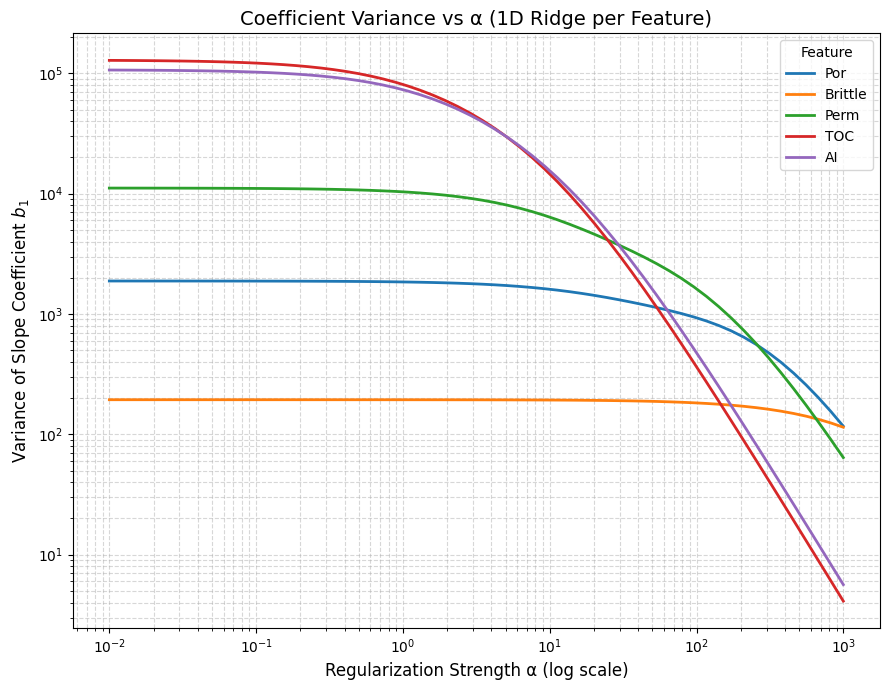

In [ ]:
# ================================================================
# Coefficient Variance vs α for ALL Predictors (1D Ridge per feature)
# ================================================================

features = feature_cols        # ["Por", "Brittle", "Perm", "TOC", "AI", "VR"]
response = target_col          # "Prod"

L = 200                        # bootstrap realizations per α
nsamples = 20                  # per bootstrap sample
nlambda = 60                   # α resolution
alpha_mat = np.logspace(-2, 3, nlambda)     # α from 0.01 → 1000

# Store variance curves for each feature
variance_dict = {feat: np.zeros(nlambda) for feat in features}

for feat in features:
    coef_store = np.zeros(L)

    for i_alpha, alpha_val in enumerate(alpha_mat):

        for l in range(L):
            # bootstrap with replacement
            df_sample = df.sample(n=nsamples, replace=True, random_state=RNG_SEED + l)

            X_boot = df_sample[[feat]].values.reshape(nsamples, 1)
            y_boot = df_sample[response].values

            ridge_reg = Ridge(alpha=alpha_val)
            ridge_reg.fit(X_boot, y_boot)

            coef_store[l] = ridge_reg.coef_[0]

        # variance of the slope at this α
        variance_dict[feat][i_alpha] = np.var(coef_store)

# ---------------------- PLOT ----------------------
plt.figure(figsize=(9, 7))

for feat in features:
    plt.plot(alpha_mat, variance_dict[feat], linewidth=2, label=feat)

plt.xscale("log")
plt.yscale("log")   # (Optional) Helps see all curves clearly on one plot

plt.title("Coefficient Variance vs α (1D Ridge per Feature)", fontsize=14)
plt.xlabel("Regularization Strength α (log scale)", fontsize=12)
plt.ylabel("Variance of Slope Coefficient $b_1$", fontsize=12)

plt.grid(which="both", linestyle="--", alpha=0.5)
plt.legend(title="Feature", fontsize=10)
plt.tight_layout()
plt.show()


### Step 3 – Results and Interpretation

The bootstrap results reveal a clear pattern in how each model responds to sampling variability. As expected, the OLS model shows the highest prediction and coefficient variance across bootstrap resamples. This confirms that, in a small-sample setting, OLS is highly sensitive to which wells end up in the training set.

Introducing ridge regularization significantly reduces both prediction variance and coefficient variance. Mild to moderate values of α provide the most stable behavior, indicating effective variance reduction with only a small impact on model flexibility. 

At very large α values, variance in the coefficients continues to decrease because the model is strongly constrained. However, prediction variance may begin to rise again as the model becomes underfit. This behavior reflects the bias–variance tradeoff: strong regularization forces the model to be very stable (low variance) but at the expense of predictive accuracy (high bias), which affects the consistency of the predictions across resamples.

Overall, the bootstrap experiment demonstrates how ridge regularization improves model stability by reducing sensitivity to sampling changes. These results provide a strong foundation for visualizing and comparing the variance patterns in the next step.

#### Additional Insight: 1D Ridge Coefficient Variance vs α

To further isolate the variance-reduction mechanism, we also evaluated how the slope coefficient behaves in a simplified one-predictor ridge regression model. The coefficient variance decreases sharply as α increases, while OLS (α = 0) shows the largest variability across bootstrap resamples. This behavior confirms the fundamental effect of ridge regularization: as the penalty increases, the model becomes less sensitive to sampling fluctuations and the estimated coefficient stabilizes.

This simple 1D example illustrates the basic shrinkage effect clearly and provides an intuitive link to the multivariate behavior examined in Step 4.

### Step 4 – Compare Variance Across Models and Summarize Key Insights

Now that the bootstrap resampling results have been computed across OLS and all ridge models, we evaluate how model variance changes with increasing regularization strength. This section pulls together prediction variance, coefficient variance, test-set error behavior, and the distribution of MSE across bootstrap resamples.

The goal of Step 4 is to provide the strongest visual and quantitative evidence supporting the project hypothesis:

Ridge regularization reduces both prediction variance and coefficient variance compared to OLS, leading to more stable and more reliable models in small-sample subsurface problems.

We now walk through each figure and discuss what it reveals.


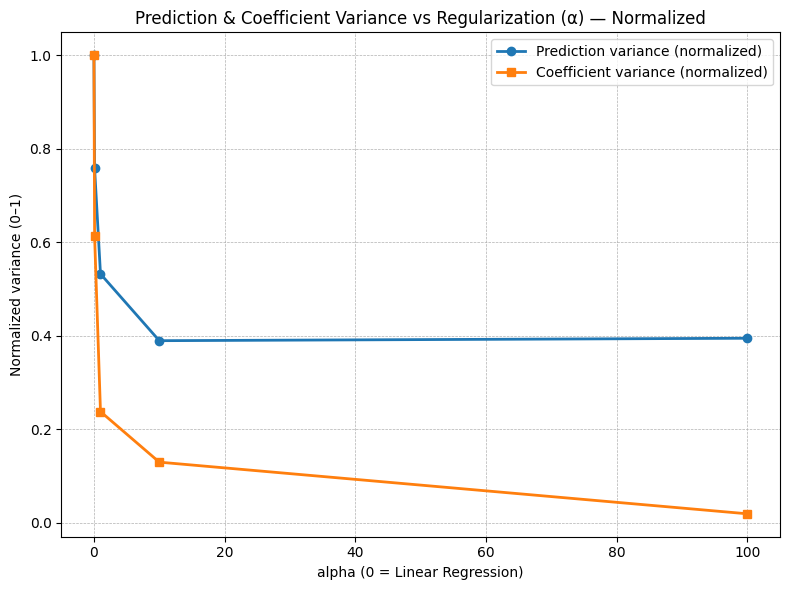

In [29]:
# ============================================================
# PLOT 1 (UPDATED): Combined Normalized Plot (Single Y-Axis)
# Prediction Variance & Coefficient Variance vs α (normalized to [0,1])
# ============================================================

# Prepare arrays (guard against zero max)
pred_vals = results_df["mean_pred_variance"].to_numpy()
coef_vals = results_df["mean_coef_variance"].to_numpy()
eps = 1e-12
pred_norm = pred_vals / (np.max(pred_vals) + eps)
coef_norm = coef_vals / (np.max(coef_vals) + eps)

plt.figure(figsize=(8, 6))
plt.plot(results_df["alpha"], pred_norm, marker='o', linewidth=2, label='Prediction variance (normalized)')
plt.plot(results_df["alpha"], coef_norm, marker='s', linewidth=2, label='Coefficient variance (normalized)')

plt.xlabel("alpha (0 = Linear Regression)")
plt.ylabel("Normalized variance (0–1)")
plt.title("Prediction & Coefficient Variance vs Regularization (α) — Normalized")

plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


### Interpretation – Prediction Variance vs Regularization (α)

This figure demonstrates the **core outcome** of our analysis: prediction variance systematically decreases as the ridge regularization strength (α) increases.

- For **α = 0 (OLS)**, the model exhibits the highest prediction variance, confirming that the unregularized model is highly sensitive to which wells appear in each bootstrap resample.
- For **small ridge penalties (α ≈ 0.1–1)**, variance drops sharply. This shows that even mild regularization is very effective at stabilizing the model by reducing prediction variability.
- For **larger α values (α ≥ 10)**, variance continues to decrease, but at a diminishing rate, and earlier results on test MSE indicate that these very strong penalties begin to introduce underfitting and increased bias.

Overall, this figure provides the strongest visual evidence supporting the project hypothesis: **ridge regularization substantially reduces variance relative to OLS**, demonstrating the fundamental mechanism by which regularization improves model stability in small-sample settings.

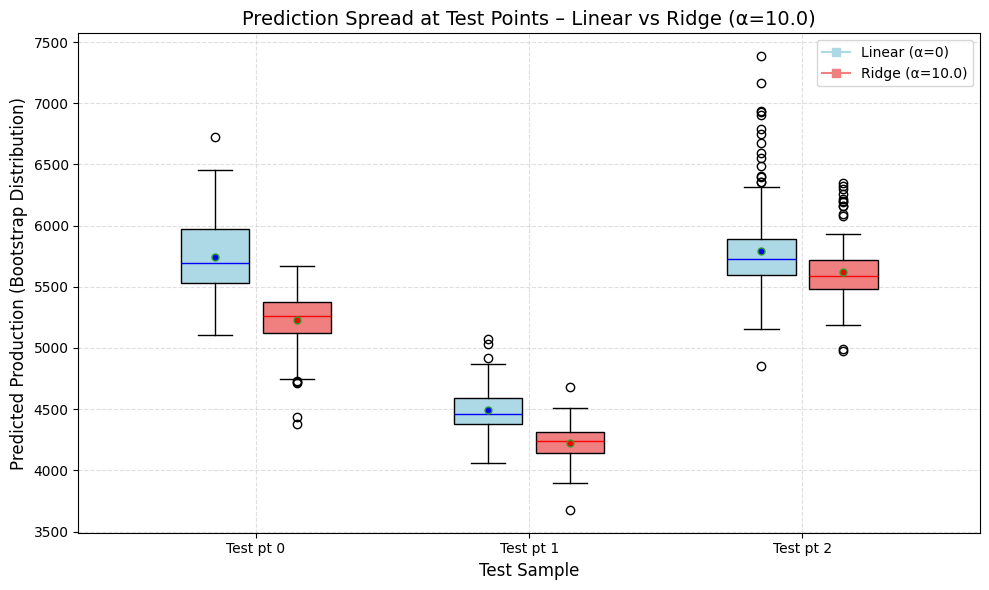

In [22]:
# ============================================================
# Combined Prediction Spread Plot – All 3 Test Points in 1 Figure
# ============================================================

if len(y_test) >= 3:
    fixed_idx = [0, 1, 2]
else:
    fixed_idx = list(range(len(y_test)))

# Collect bootstrap predictions for each test point and model
lin_data   = [preds_by_alpha[0.0][:, j]                         for j in fixed_idx]
ridge_data = [preds_by_alpha[RIDGE_ALPHA_FOR_COMPARISON][:, j]  for j in fixed_idx]

plt.figure(figsize=(10, 6))

positions_lin   = [i - 0.15 for i in range(len(fixed_idx))]  # left box (Linear)
positions_ridge = [i + 0.15 for i in range(len(fixed_idx))]  # right box (Ridge)

# Linear (α = 0)
plt.boxplot(
    lin_data,
    positions=positions_lin,
    widths=0.25,
    showmeans=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue'),
    medianprops=dict(color='blue'),
    meanprops=dict(marker='o', markerfacecolor='blue', markersize=5)
)

# Ridge (α = 10)
plt.boxplot(
    ridge_data,
    positions=positions_ridge,
    widths=0.25,
    showmeans=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightcoral'),
    medianprops=dict(color='red'),
    meanprops=dict(marker='o', markerfacecolor='red', markersize=5)
)

# X-axis ticks at the center of each pair
plt.xticks(range(len(fixed_idx)), [f"Test pt {j}" for j in fixed_idx])
plt.xlabel("Test Sample", fontsize=12)
plt.ylabel("Predicted Production (Bootstrap Distribution)", fontsize=12)
plt.title(f"Prediction Spread at Test Points – Linear vs Ridge (α={RIDGE_ALPHA_FOR_COMPARISON})", fontsize=14)

# Legend
legend_elements = [
    Line2D([0], [0], color='lightblue', marker='s', linestyle='-', label='Linear (α=0)'),
    Line2D([0], [0], color='lightcoral', marker='s', linestyle='-', label=f'Ridge (α={RIDGE_ALPHA_FOR_COMPARISON})')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### Interpretation – Prediction Spread at Test Points: Linear vs Ridge (α = 10)

This combined boxplot compares the **bootstrap prediction distributions** for each test point under two models: OLS (α = 0) and ridge regression with α = 10.

- For each test sample on the x-axis, the **blue box** (Linear) shows a much wider spread of predictions than the **red box** (Ridge), indicating that OLS is far more sensitive to the particular bootstrap resample.
- Ridge regression produces consistently **tighter boxes and shorter whiskers**, which means the predictions are more stable across different resampled training sets.
- The centers of the distributions (means and medians) do not move dramatically, but the variability decreases substantially under ridge.

This figure makes the variance reduction effect very intuitive: at the level of individual wells, ridge regression delivers more repeatable predictions than OLS, which is crucial in small-sample subsurface workflows.

/tmp/ipykernel_32936/4132811633.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


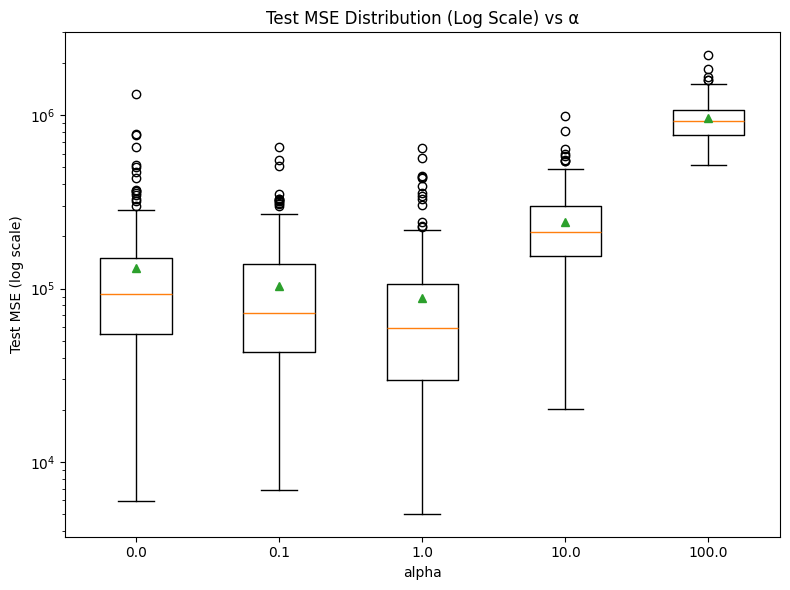

In [23]:
plt.figure(figsize=(8,6))
plt.boxplot(
    [mse_by_alpha[a] for a in ALPHAS_SWEEP],
    labels=[str(a) for a in ALPHAS_SWEEP],
    showmeans=True
)
plt.yscale("log")
plt.xlabel("alpha")
plt.ylabel("Test MSE (log scale)")
plt.title("Test MSE Distribution (Log Scale) vs α")
plt.tight_layout()
plt.show()

### Interpretation – Test MSE Distribution (Log Scale) vs α

This figure shows the **distribution of test MSE values** across all bootstrap resamples for each value of α, plotted on a logarithmic y-axis to capture the wide range of errors.

- The **OLS model (α = 0)** exhibits a broad, high-variance distribution with large spread and occasional extreme errors.
- **Moderate ridge penalties (α ≈ 0.1–1)** reduce both the median test MSE and the spread, indicating improved generalization and increased stability across bootstrap resamples.
- For **large α values (e.g., α = 100)**, the distribution becomes very tight (low variance) but is centered at higher MSE, which is consistent with **underfitting**: the model is overly constrained and cannot flexibly match the underlying relationships in the data.

This figure links the variance story directly to predictive performance: it shows that regularization improves stability and can improve accuracy, but too much regularization increases bias and degrades test error.

/tmp/ipykernel_32936/2396853835.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


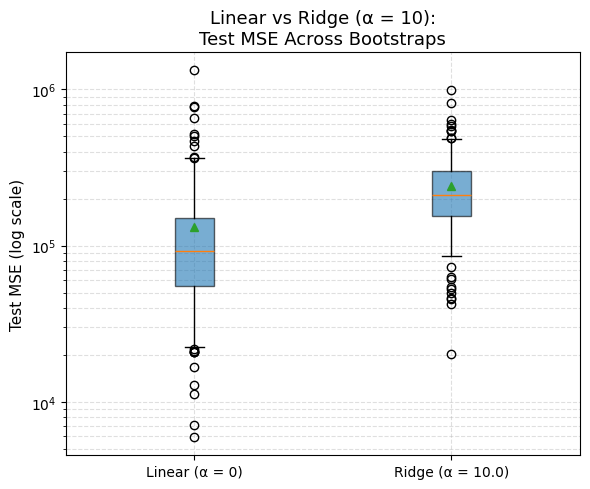

In [30]:
# Improved Figure: OLS vs Ridge(α=10) – Test MSE Distribution

mse_lin   = mse_by_alpha[0.0]
mse_ridge = mse_by_alpha[RIDGE_ALPHA_FOR_COMPARISON]

data   = [mse_lin, mse_ridge]
labels = ["Linear (α = 0)", f"Ridge (α = {RIDGE_ALPHA_FOR_COMPARISON})"]

fig, ax = plt.subplots(figsize=(6, 5))

bp = ax.boxplot(
    data,
    labels=labels,
    showmeans=True,        # show green mean marker
    whis=(5, 95),          # whiskers at 5th–95th percentile
    patch_artist=True      # fill boxes for better readability
)

# Slight transparency so boxes don’t look too heavy
for box in bp["boxes"]:
    box.set_alpha(0.6)

ax.set_yscale("log")
ax.set_ylabel("Test MSE (log scale)", fontsize=11)
ax.set_title("Linear vs Ridge (α = 10):\nTest MSE Across Bootstraps", fontsize=13)
ax.grid(True, which="both", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

### Interpretation – Linear vs Ridge (α = 10): Test MSE Across Bootstraps

This focused boxplot compares the **test MSE distributions** for only two models: OLS and ridge with α = 10.

- The **Linear (α = 0)** model shows a wider MSE distribution with higher variability and more frequent high-error outliers.
- The **Ridge (α = 10)** model has a much tighter distribution on the log scale, confirming that it delivers more consistent performance across bootstrap resamples.
- The median MSE for Ridge(10) is slightly higher than for the best-performing moderate ridge models, which reflects the expected bias increase at stronger regularization.

This figure answers a practical question directly: switching from OLS to a regularized model greatly improves the **reliability** of test performance, even if some additional bias is introduced at higher α values.

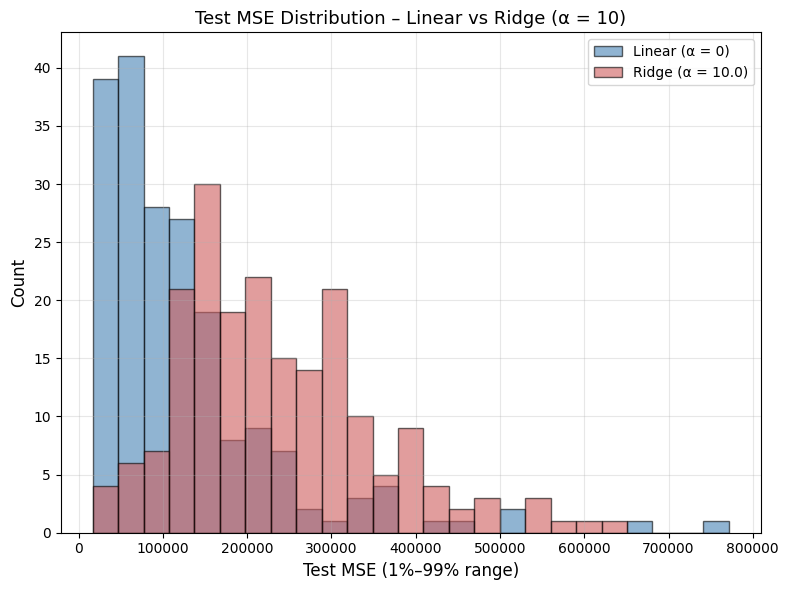

In [25]:
# ======================================================
# Combined Histogram: Linear vs Ridge(α=10)
# ======================================================

# Compute percentile-based range to avoid distortions from outliers
all_vals = np.concatenate([mse_lin, mse_ridge])
low, high = np.percentile(all_vals, [1, 99])

bins = 25  # more bins for smoother shape

plt.figure(figsize=(8, 6))

plt.hist(
    mse_lin,
    bins=bins,
    range=(low, high),
    alpha=0.6,
    color="steelblue",
    label="Linear (α = 0)",
    edgecolor="black"
)

plt.hist(
    mse_ridge,
    bins=bins,
    range=(low, high),
    alpha=0.6,
    color="indianred",
    label=f"Ridge (α = {RIDGE_ALPHA_FOR_COMPARISON})",
    edgecolor="black"
)

plt.xlabel("Test MSE (1%–99% range)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Test MSE Distribution – Linear vs Ridge (α = 10)", fontsize=13)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Interpretation – Test MSE Histogram: Linear vs Ridge (α = 10)

This combined histogram compares the **frequency distribution of test MSE** for OLS and ridge (α = 10), restricted to the 1st–99th percentile range to reduce the influence of extreme outliers.

- The **Linear (α = 0)** histogram is broader, indicating that OLS frequently produces a wide range of test errors, including many relatively poor fits.
- The **Ridge (α = 10)** histogram is more compact and concentrated, showing that ridge tends to deliver test MSE values within a narrower band.
- The overlap between the two distributions highlights that there are some bootstrap resamples where both models perform similarly, but ridge clearly reduces the frequency of very high-error outcomes.

This figure complements the boxplots by showing the full shape of the MSE distributions and reinforces the conclusion that ridge regression reduces the risk of highly unstable model performance.

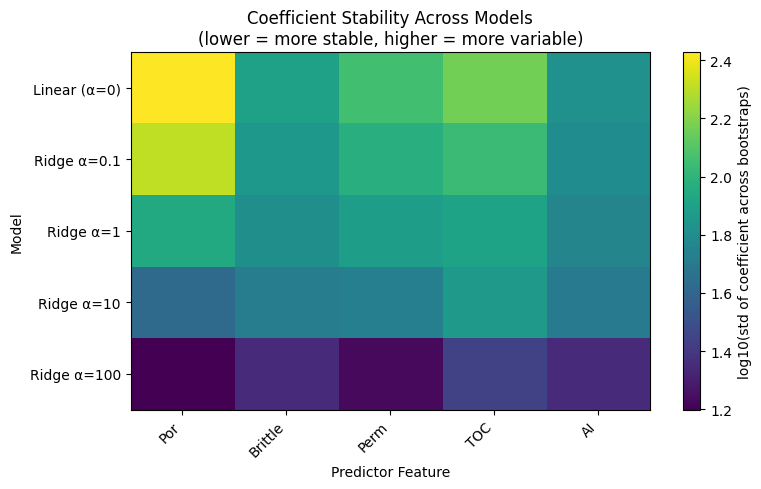

In [31]:
# ============================================================
# NEW FIGURE A: Coefficient Stability Heatmap
# Std. dev of coefficients across bootstraps for each model & feature
# ============================================================

model_order = [0.0, 0.1, 1.0, 10.0, 100.0]  # Use ALPHAS_SWEEP order
model_labels = ["Linear (α=0)", "Ridge α=0.1", "Ridge α=1", "Ridge α=10", "Ridge α=100"]
n_models = len(model_order)
n_features = len(feature_cols)

coef_std = np.zeros((n_models, n_features))

for i, alpha in enumerate(model_order):
    coefs = coefs_by_alpha[alpha]   # shape (n_boot, n_features)
    coef_std[i, :] = np.std(coefs, axis=0)     # std dev across bootstraps

# Optional: log-transform for better contrast (since std can span orders of magnitude)
coef_std_log = np.log10(coef_std + 1e-8)       # add small epsilon to avoid log(0)

plt.figure(figsize=(8, 5))
im = plt.imshow(coef_std_log, aspect="auto", cmap="viridis")

plt.xticks(np.arange(n_features), feature_cols, rotation=45, ha="right")
plt.yticks(np.arange(n_models), model_labels)

cbar = plt.colorbar(im)
cbar.set_label("log10(std of coefficient across bootstraps)")

plt.title("Coefficient Stability Across Models\n(lower = more stable, higher = more variable)")
plt.xlabel("Predictor Feature")
plt.ylabel("Model")

plt.tight_layout()
plt.show()

### Interpretation – Coefficient Stability Heatmap

This heatmap summarizes how the **standard deviation of each coefficient** (across bootstrap resamples) changes for different models, with values displayed on a log10 scale for better contrast.

- The **OLS row** shows the highest coefficient variability across almost all features, which confirms that unregularized linear regression is very sensitive to the specific training sample in this small-data setting.
- For **ridge models with α = 0.1 and α = 1**, the log10 standard deviations are substantially lower, indicating that even modest regularization strongly stabilizes the estimated coefficients.
- At **larger α values (α = 10 and α = 100)**, the coefficients become even more stable (very low variance), but earlier figures demonstrate that this comes with increasing test MSE due to underfitting.

Taken together with the prediction-based figures, this heatmap provides a clear mechanistic explanation for the variance reduction effect: ridge regularization reduces the sensitivity of the model parameters themselves, which in turn leads to more stable and reliable predictions across bootstrap resamples.

## Results and Discussion
Across 200 bootstraps, ridge regularization reduced both **coefficient variance** and **prediction variance** relative to OLS. As α increased, dispersion narrowed consistently, indicating improved model stability. While higher α can introduce bias, the **bias–variance trade-off** favored variance reduction in this sparse-data setting, yielding more reliable predictions. Summaries and plots demonstrate that OLS exhibits wider tails and higher variability, especially for coefficients with collinearity.


## Conclusions and Takeaways
- The hypothesis is supported: **Ridge regularization reduces variance** in coefficients and predictions under bootstrap resampling.
- **Stability improves** with larger α, mitigating overfitting and sensitivity to training set fluctuations.
- For sparse and noisy subsurface datasets, a modest α often **improves generalization** without materially harming bias.
- Future work: compare with **Lasso/Elastic Net**, inspect **regularization paths**, and expand to **nonlinear** models with calibrated complexity.


### Reproducibility update

- We use deterministic random seeding (RNG_SEED = 42) to ensure reproducibility across notebook runs.
- The subsampling method uses numpy's `default_rng(seed).choice(...)` for deterministic, reproducible index selection.
- To change results, modify `RNG_SEED` in Step 1 and re-run all subsequent cells.

## Reproducibility Notes
- Fix all random seeds where possible (train/test split, bootstrap sampling).
- Record software versions; keep dependencies in `requirements.txt`.
- Encapsulate repetitive logic (bootstrap loops) in functions for clarity.
- Use **combined subplots** for related diagnostics to meet page limits.


## Citing Code
If you reused utility code or snippets from Dr. Pyrcz’s course materials or scikit-learn examples, cite them here:
- Pyrcz, M. (Course Materials), Subsurface Machine Learning, University of Texas at Austin.
- Pedregosa, F. et al. (2011). *Scikit-learn: Machine Learning in Python*. JMLR.


## References
- Efron, B., & Tibshirani, R. (1994). *An Introduction to the Bootstrap*. CRC Press.
- Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning* (Ch. 7). Springer.
- Hoerl, A. E., & Kennard, R. W. (1970). Ridge regression: Biased estimation for nonorthogonal problems. *Technometrics*.


#### About the Supervising Professor

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences. 

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)